In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import tensorflow as tf
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read labels..
dataframe = pd.read_csv('/kaggle/input/facial-keypoint-detection/training.csv')
dataframe.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [3]:
# Check for missing data..
print("Number of elements in the dataset:        ", dataframe.to_numpy().size)
print("Number of missing elements in the dataset:", dataframe.isna().sum().sum())

Number of elements in the dataset:         211470
Number of missing elements in the dataset: 105412


In [4]:
print(dataframe.shape)
dataframe = dataframe.dropna()
print(dataframe.shape)

(7049, 30)
(2140, 30)


In [5]:
def get_train_data(image_path, dataframe):
    X_train = []
    Y_train = dataframe.to_numpy() * 224 / 96
    for i in dataframe.index:
        img_raw = tf.io.read_file(image_path + str(i) + ".jpg")
        image = tf.image.decode_jpeg(img_raw, channels=3)
        image = tf.cast(image, dtype=tf.float32)
        image = tf.image.resize(image, (224, 224)) / 255.0
        X_train.append(image)
    return np.array(X_train), Y_train

In [6]:
# get the list containing the image paths
train_path = "/kaggle/input/facial-keypoint-detection/images/train_images/"
test_path = "/kaggle/input/facial-keypoint-detection/images/test_images/"

X_train, Y_train = get_train_data(train_path, dataframe)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, shuffle=True)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(1712, 224, 224, 3)
(1712, 30)
(428, 224, 224, 3)
(428, 30)


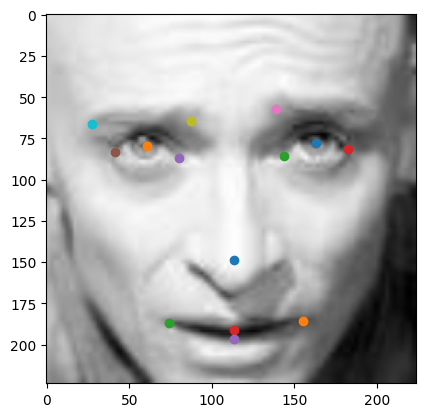

In [7]:
# check if X_train and Y_train are reasonable
img_index = random.randint(0, Y_train.shape[0])
plt.imshow(X_train[img_index])
for index in range(0, Y_train.shape[1], 2):
    # x and y coordinates are given in sequence
    plt.scatter(Y_train[img_index][index], Y_train[img_index][index + 1])
plt.show()

In [8]:
# consider also using Upsampling(21) and Downsampling(3) before feature extractor
# instead of using tf.image.resize
# or consider upsampling using Conv2DTranspose()
detector = tf.keras.Sequential(layers=[
    tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  weights='imagenet'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    # 1024 -> 512 -> 30 --> loss: 14.3266 - mae: 2.8708
    # 512 -> 256 -> 30 --> loss: 15.2974 - mae: 2.9595
    # 256 -> 128 -> 30 --> loss: 15.7286 - mae: 2.9837
    # 2048 -> 1024 -> 30 --> loss: 13.4422 - mae: 2.7916
    tf.keras.layers.Dense(units=1024,
                         activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=512,
                         activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=30,
                         activation='linear')
])
# freeze the layers of mobilenet to make use of transfer learning
detector.layers[0].trainable=False
detector.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                             

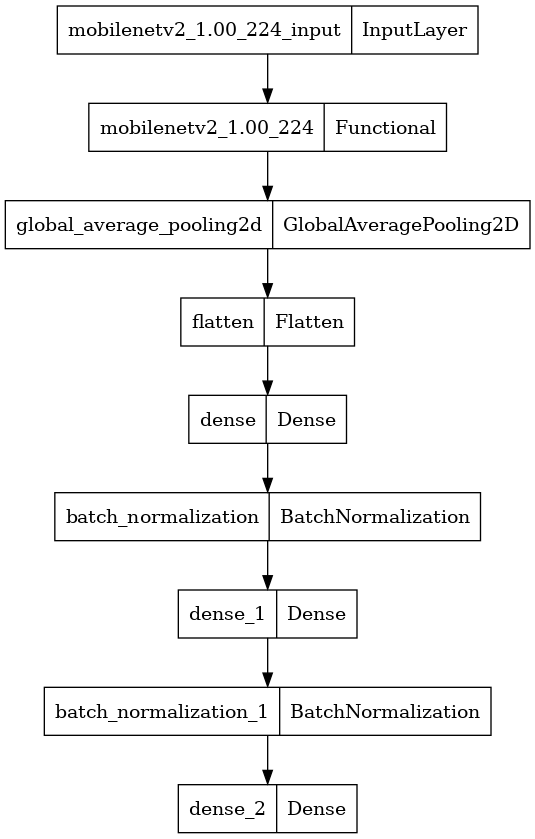

In [9]:
tf.keras.utils.plot_model(detector)

In [10]:
detector.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [11]:
EPOCHS=50
detector.fit(X_train, Y_train, epochs=EPOCHS, validation_data=(X_valid, Y_valid))

Epoch 1/50
54/54 [==============================] - 14s 70ms/step - loss: 14127.0957 - mae: 110.5405 - val_loss: 13671.0830 - val_mae: 108.5345
Epoch 2/50
54/54 [==============================] - 2s 38ms/step - loss: 13033.7783 - mae: 105.6375 - val_loss: 12082.7080 - val_mae: 101.0083
Epoch 3/50
54/54 [==============================] - 2s 38ms/step - loss: 10543.7979 - mae: 93.2725 - val_loss: 8134.5396 - val_mae: 80.1088
Epoch 4/50
54/54 [==============================] - 2s 38ms/step - loss: 7341.2822 - mae: 74.6298 - val_loss: 4905.6714 - val_mae: 57.5461
Epoch 5/50
54/54 [==============================] - 2s 38ms/step - loss: 4415.8267 - mae: 53.5466 - val_loss: 2809.0891 - val_mae: 39.3809
Epoch 6/50
54/54 [==============================] - 2s 38ms/step - loss: 2374.5723 - mae: 35.2039 - val_loss: 1443.5421 - val_mae: 26.1542
Epoch 7/50
54/54 [==============================] - 2s 38ms/step - loss: 1202.6835 - mae: 23.4282 - val_loss: 654.6277 - val_mae: 18.9801
Epoch 8/50
54/54 [

1/1 [==============================] - 1s 1s/step


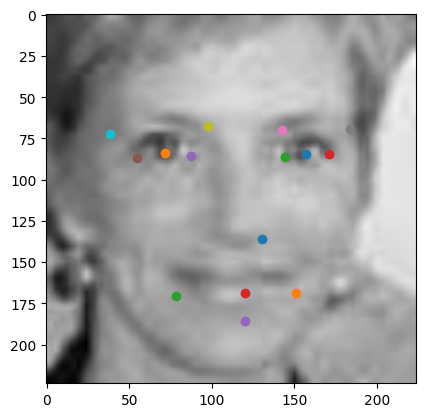

1/1 [==============================] - 0s 22ms/step


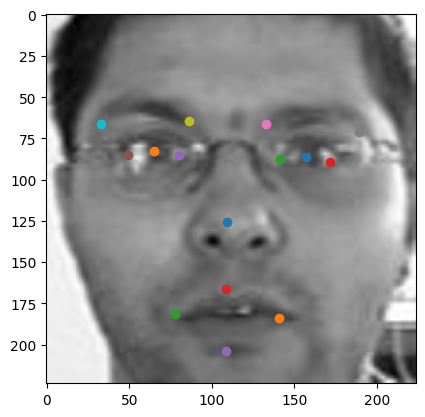

1/1 [==============================] - 0s 22ms/step


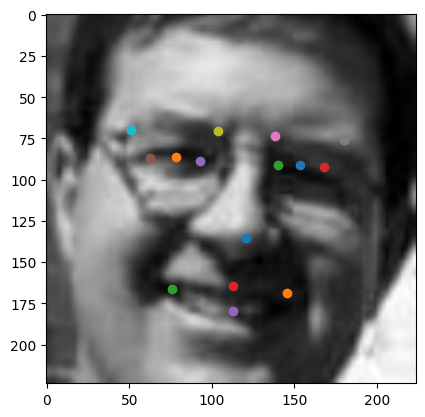

1/1 [==============================] - 0s 23ms/step


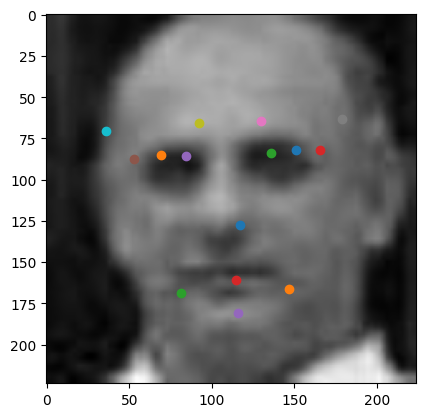

1/1 [==============================] - 0s 23ms/step


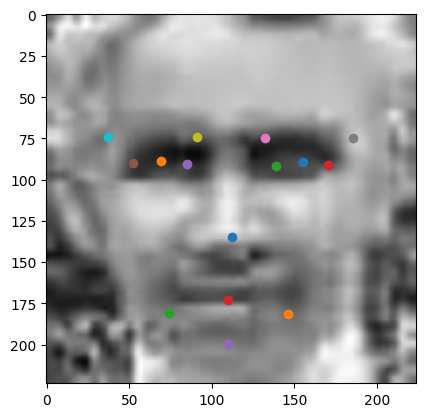

1/1 [==============================] - 0s 26ms/step


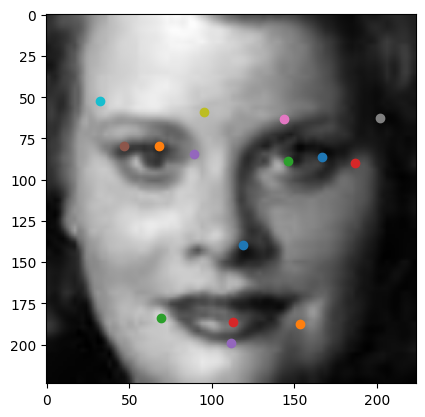

1/1 [==============================] - 0s 22ms/step


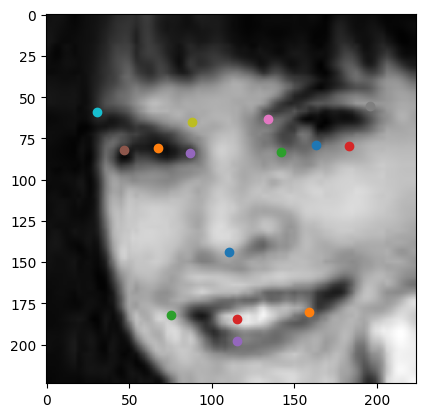

1/1 [==============================] - 0s 24ms/step


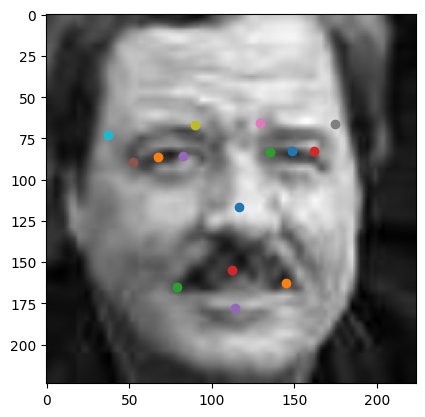

1/1 [==============================] - 0s 23ms/step


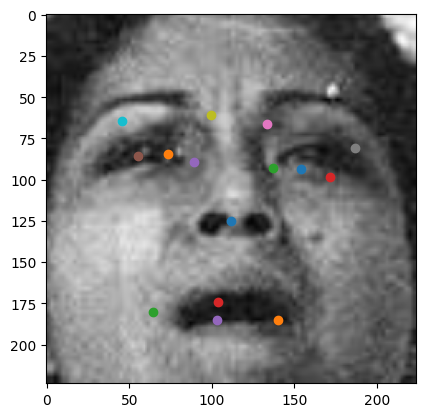

1/1 [==============================] - 0s 22ms/step


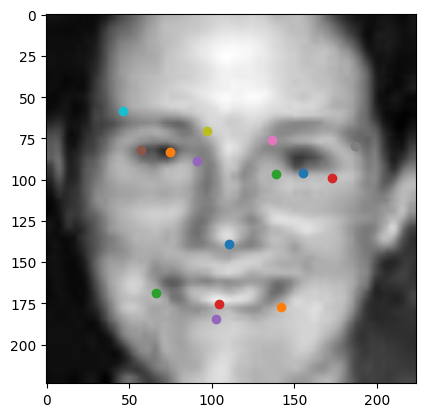

In [12]:
# visualise prediction 
test_count = 10
# presume that images are named in ordered fashion
test_image_count = len(os.listdir(test_path))
indices = [np.random.randint(0, test_image_count) for _ in range(test_count)]
for i in indices:
    img_raw = tf.io.read_file(test_path + str(i) + ".jpg")
    image = tf.image.decode_jpeg(img_raw, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    image = tf.image.resize(image, (224, 224)) / 255.0
    plt.imshow(image)
    image = tf.reshape(image, shape=(1, 224, 224, 3))
    keypoints = detector.predict(image)[0]
    for index in range(0, keypoints.size, 2):
        # x and y coordinates are given in sequence
        plt.scatter(keypoints[index], keypoints[index + 1])
    plt.show()